<a href="https://colab.research.google.com/github/snpsuen/Deep_Learning_Data/blob/main/Pytorch_RNN_LSTM_AT_example02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
print("Type of df = ", type(df))
print("df.shape = ", df.shape)
timeseries = df[["Passengers"]].values.astype('float32')
print("Type of timeseries = ", type(timeseries))
print("timeseries.shape = ", timeseries.shape)

Type of df =  <class 'pandas.core.frame.DataFrame'>
df.shape =  (144, 2)
Type of timeseries =  <class 'numpy.ndarray'>
timeseries.shape =  (144, 1)


In [3]:
# train-test split for time series
proportion = 0.70
train_size = int(len(timeseries) * proportion)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print("Type of train = ", type(train))
print("train.shape = ", train.shape)
print("Type of test = ", type(test))
print("test.shape = ", test.shape)

def create_dataset(numarray, lookback):
    """Transform a time series into a prediction dataset

    Args:
        numarray: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(numarray)-lookback):
        feature = numarray[i:i+lookback]
        target = numarray[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print("Type of X_train, type of y_train = ", type(X_train), type(y_train))
print("X_train.shape(samples, timesteps, features), y_train.shape(samples, features) = ", X_train.shape, y_train.shape)
print("Type of X_test, type of y_test = ", type(X_train), type(y_train))
print("X_test.shape(samples, timesteps, features), y_test.shape(samples, features) = ", X_test.shape, y_test.shape)

Type of train =  <class 'numpy.ndarray'>
train.shape =  (100, 1)
Type of test =  <class 'numpy.ndarray'>
test.shape =  (44, 1)
Type of X_train, type of y_train =  <class 'torch.Tensor'> <class 'torch.Tensor'>
X_train.shape(samples, timesteps, features), y_train.shape(samples, features) =  torch.Size([96, 4, 1]) torch.Size([96, 1])
Type of X_test, type of y_test =  <class 'torch.Tensor'> <class 'torch.Tensor'>
X_test.shape(samples, timesteps, features), y_test.shape(samples, features) =  torch.Size([40, 4, 1]) torch.Size([40, 1])


<ipython-input-3-1036116015>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=50, out_features=1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

In [7]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
mseloss = nn.MSELoss()
trainloader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = mseloss(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 != 0:
        continue

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(mseloss(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(mseloss(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

<ipython-input-7-644846404>:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(mseloss(y_pred, y_train))
<ipython-input-7-644846404>:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(mseloss(y_pred, y_test))


Epoch 0: train RMSE 233.6622, test RMSE 427.5461
Epoch 100: train RMSE 186.9379, test RMSE 378.6415
Epoch 200: train RMSE 151.1013, test RMSE 339.8578
Epoch 300: train RMSE 120.7379, test RMSE 304.8968
Epoch 400: train RMSE 96.8955, test RMSE 273.8519
Epoch 500: train RMSE 67.6644, test RMSE 231.8806
Epoch 600: train RMSE 50.1996, test RMSE 200.4539
Epoch 700: train RMSE 38.7483, test RMSE 176.1918
Epoch 800: train RMSE 31.5425, test RMSE 157.2260
Epoch 900: train RMSE 27.6637, test RMSE 140.0909
Epoch 1000: train RMSE 25.5066, test RMSE 128.3764
Epoch 1100: train RMSE 24.2129, test RMSE 119.3980
Epoch 1200: train RMSE 22.0653, test RMSE 114.0299
Epoch 1300: train RMSE 21.0136, test RMSE 106.6673
Epoch 1400: train RMSE 20.0878, test RMSE 103.0724
Epoch 1500: train RMSE 19.3898, test RMSE 98.5077
Epoch 1600: train RMSE 18.7835, test RMSE 95.1037
Epoch 1700: train RMSE 18.2928, test RMSE 93.1866
Epoch 1800: train RMSE 18.0027, test RMSE 91.6168
Epoch 1900: train RMSE 17.7334, test RMSE 9

<ipython-input-8-396101480>:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)
<ipython-input-8-396101480>:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)


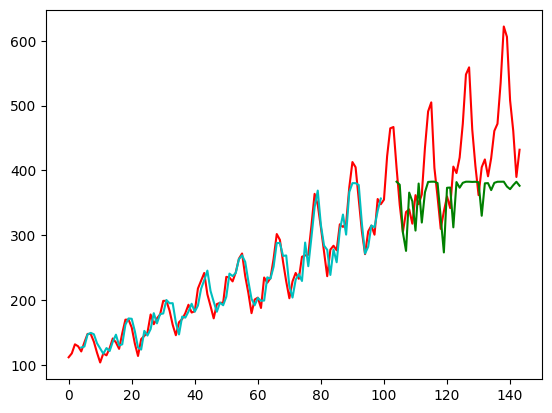

In [8]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    # y_pred = model(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)
# plot
plt.plot(timeseries, c='r')
plt.plot(train_plot, c='c')
plt.plot(test_plot, c='g')
plt.show()